# Boosting in der Praxis – Übungsnotebook

## Lernziele

Nach diesem Notebook kannst du …

- erklären, was Boosting grundlegend macht (Idee: viele schwache Lerner → starkes Modell),
- an Entscheidungsgrenzen sehen, wie sich AdaBoost und Gradient Boosting Schritt für Schritt verändern,
- verstehen, wie `n_estimators`, `learning_rate` und `max_depth` das Modell beeinflussen,
- die Performance verschiedener Boosting-Modelle vergleichen,
- und erste Hyperparameter-Experimente durchführen.

In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from copy import deepcopy

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

In [19]:
# 2D-Datensatz, damit wir Entscheidungsgrenzen gut plotten können
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.0,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("Trainingsdaten:", X_train.shape)
print("Testdaten:     ", X_test.shape)


Trainingsdaten: (750, 2)
Testdaten:      (250, 2)


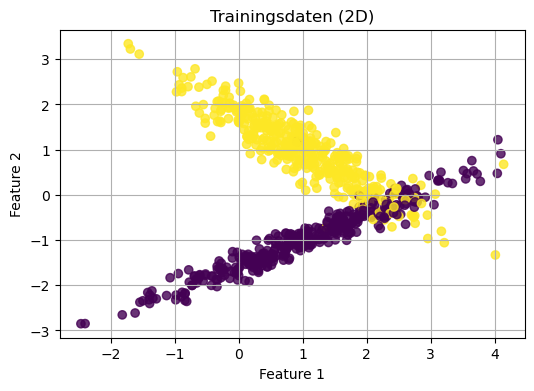

In [20]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.8)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_title("Trainingsdaten (2D)")
plt.show()


> **Aufgabe 1 – Datensatz verstehen**
>
> - Wie sind die beiden Klassen ungefähr verteilt?
> - Meinst du, eine **lineare** Trennlinie würde reichen?
> - Wo erwartest du, dass ein Modell sich eher schwer tun wird (Regionen mit gemischten Punkten)?


In [21]:
def plot_decision_boundary(model, X, y, ax=None, title=""):
    """
    Plottet die Entscheidungsgrenze eines Klassifikators für 2D-Daten.
    """
    if ax is None:
        fig, ax = plt.subplots()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.2)
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_title(title)

    return ax

Test-Accuracy (Decision Stump): 0.872


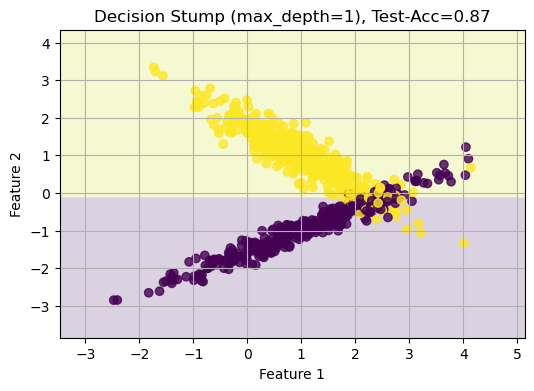

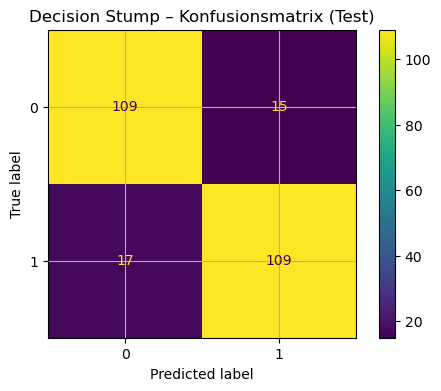

In [22]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_pred_stump = stump.predict(X_test)
acc_stump = accuracy_score(y_test, y_pred_stump)
print("Test-Accuracy (Decision Stump):", acc_stump)

fig, ax = plt.subplots()
plot_decision_boundary(stump, X_train, y_train, ax=ax,
                       title=f"Decision Stump (max_depth=1), Test-Acc={acc_stump:.2f}")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_stump)
plt.title("Decision Stump – Konfusionsmatrix (Test)")
plt.show()

> **Aufgabe 2 – Decision Stump**
>
> - Wie sieht die Entscheidungsgrenze aus? Eher grob oder fein?
> - Wo siehst du Fehlklassifikationen (Punkte "in der falschen Region")?
> - Warum könnte es eine gute Idee sein, **viele** solcher einfachen Stumps zu kombinieren statt nur einen zu verwenden?


Test-Accuracy (AdaBoost, 50 Stumps): 0.876


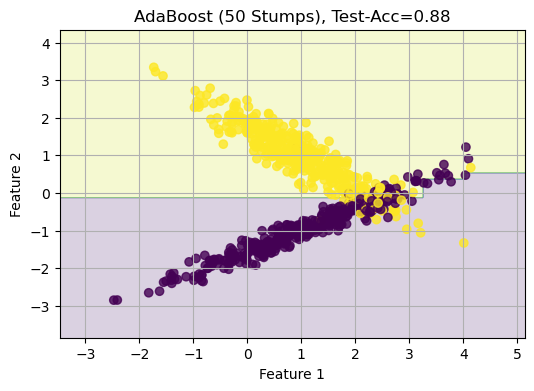

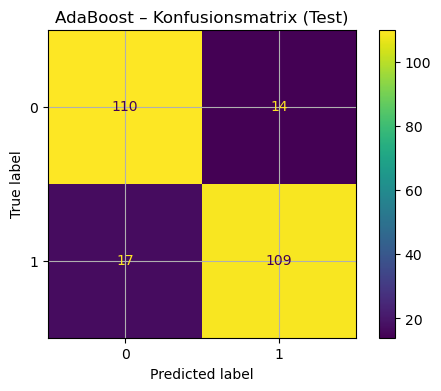

In [23]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)
acc_ada = accuracy_score(y_test, y_pred_ada)
print("Test-Accuracy (AdaBoost, 50 Stumps):", acc_ada)

fig, ax = plt.subplots()
plot_decision_boundary(ada, X_train, y_train, ax=ax,
                       title=f"AdaBoost (50 Stumps), Test-Acc={acc_ada:.2f}")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ada)
plt.title("AdaBoost – Konfusionsmatrix (Test)")
plt.show()

> **Aufgabe 3 – Boosting-Effekt**
>
> Vergleiche AdaBoost mit dem einzelnen Decision Stump:
> - Wie haben sich Accuracy und Entscheidungsgrenze verändert?
> - Wo siehst du, dass AdaBoost eine **komplexere Grenze** modellieren kann?


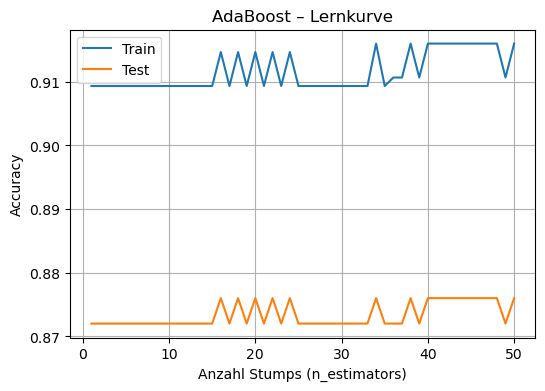

In [24]:
train_acc = []
test_acc = []
n_list = []

staged_preds_train = list(ada.staged_predict(X_train))
staged_preds_test = list(ada.staged_predict(X_test))

for i, (y_pred_train, y_pred_test) in enumerate(zip(staged_preds_train, staged_preds_test), start=1):
    train_acc.append(accuracy_score(y_train, y_pred_train))
    test_acc.append(accuracy_score(y_test, y_pred_test))
    n_list.append(i)

plt.plot(n_list, train_acc, label="Train")
plt.plot(n_list, test_acc, label="Test")
plt.xlabel("Anzahl Stumps (n_estimators)")
plt.ylabel("Accuracy")
plt.title("AdaBoost – Lernkurve")
plt.legend()
plt.show()

> **Aufgabe 4 – Lernkurve lesen**
>
> - Ab wie vielen Stumps verändert sich die Test-Accuracy kaum noch?
> - Siehst du eine Tendenz zum Overfitting (Train-Accuracy deutlich höher als Test-Accuracy)?
> - Welche Region der Kurve würdest du als "sweet spot" bezeichnen?


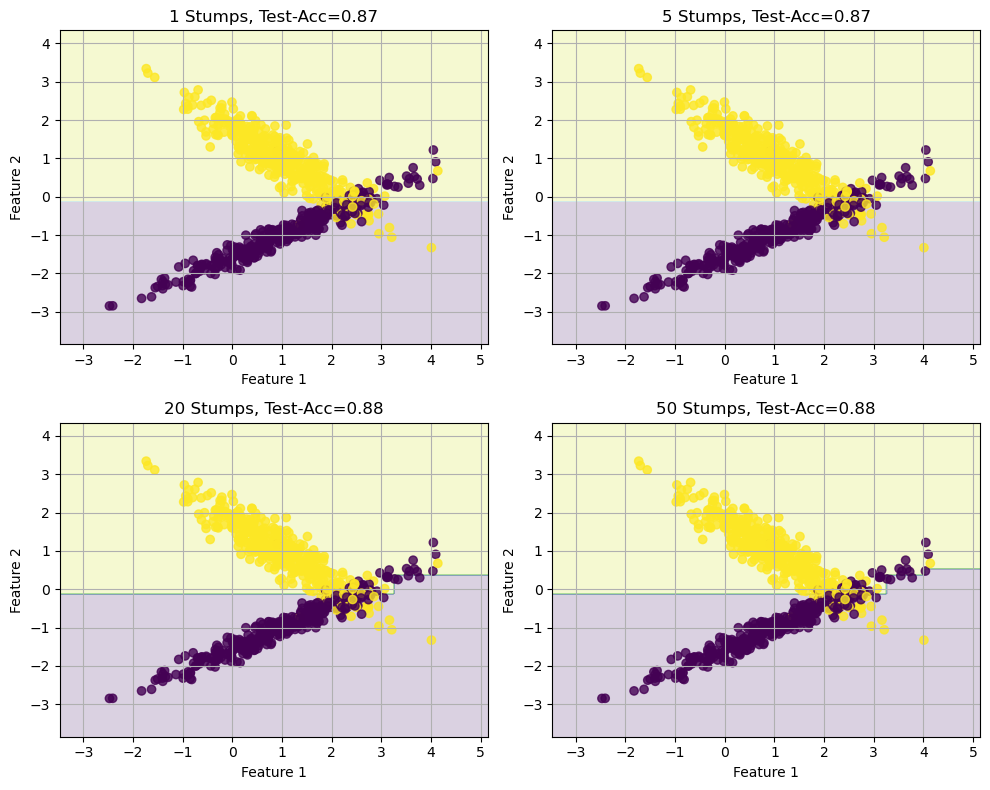

In [25]:
stages = [1, 5, 20, 50]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, n in zip(axes.ravel(), stages):
    ada_n = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=n,
        learning_rate=1.0,
        random_state=42
    )
    ada_n.fit(X_train, y_train)
    y_pred_n = ada_n.predict(X_test)
    acc_n = accuracy_score(y_test, y_pred_n)

    plot_decision_boundary(ada_n, X_train, y_train, ax=ax,
                           title=f"{n} Stumps, Test-Acc={acc_n:.2f}")

plt.tight_layout()
plt.show()

> **Aufgabe 5 – Entwicklung der Entscheidungsgrenze**
>
> - Beschreibe, wie sich die Grenze von 1 → 5 → 20 → 50 Stumps verändert.
> - Bei welcher Stufe würdest du sagen: "Jetzt ist sie komplex genug"?

Test-Accuracy (Gradient Boosting): 0.936


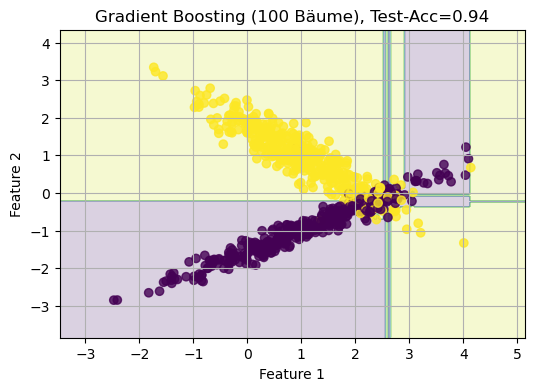

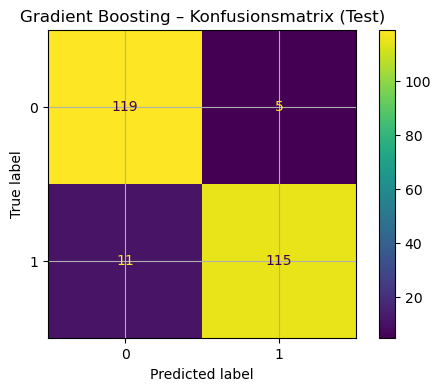

In [26]:
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
print("Test-Accuracy (Gradient Boosting):", acc_gb)

fig, ax = plt.subplots()
plot_decision_boundary(gb, X_train, y_train, ax=ax,
                       title=f"Gradient Boosting (100 Bäume), Test-Acc={acc_gb:.2f}")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb)
plt.title("Gradient Boosting – Konfusionsmatrix (Test)")
plt.show()

> **Aufgabe 6 – Vergleich von Boosting-Varianten**
>
> - Vergleiche AdaBoost und Gradient Boosting in dieser Aufgabe:
>   - Welche Accuracy erreichst du jeweils?
>   - Welche Grenze wirkt "glatter" oder "flexibler"?
> - Was könnte der Vorteil von Gradient Boosting gegenüber AdaBoost sein?


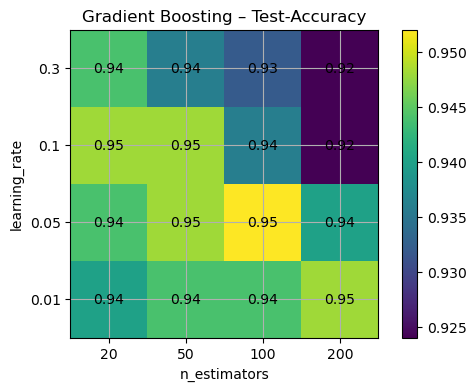

In [27]:
learning_rates = [0.01, 0.05, 0.1, 0.3]
n_estimators_list = [20, 50, 100, 200]

results = []

for lr in learning_rates:
    row = []
    for n_est in n_estimators_list:
        model = GradientBoostingClassifier(
            n_estimators=n_est,
            learning_rate=lr,
            max_depth=3,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        row.append(acc)
    results.append(row)

results = np.array(results)

fig, ax = plt.subplots()
im = ax.imshow(results, origin="lower")

ax.set_xticks(range(len(n_estimators_list)))
ax.set_yticks(range(len(learning_rates)))

ax.set_xticklabels(n_estimators_list)
ax.set_yticklabels(learning_rates)

ax.set_xlabel("n_estimators")
ax.set_ylabel("learning_rate")
ax.set_title("Gradient Boosting – Test-Accuracy")

for i in range(len(learning_rates)):
    for j in range(len(n_estimators_list)):
        ax.text(j, i, f"{results[i, j]:.2f}", ha="center", va="center")

plt.colorbar(im, ax=ax)
plt.show()

> **Aufgabe 7 – Hyperparameter-Tuning verstehen**
>
> - Welche Kombination aus `learning_rate` und `n_estimators` funktioniert hier am besten?
> - Welche Zeile zeigt eher "unterfitte" Modelle (zu einfach)?
> - Erkläre in eigenen Worten:
>   - Warum kleine `learning_rate`-Werte oft stabiler sind,
>   - aber mehr Bäume (`n_estimators`) brauchen.


Test-Accuracy (XGBoost): 0.868


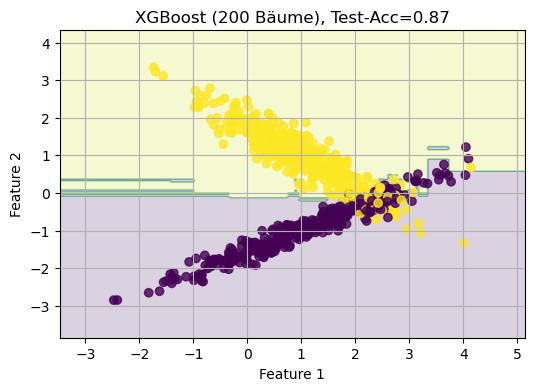

In [28]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("Test-Accuracy (XGBoost):", acc_xgb)

fig, ax = plt.subplots()
plot_decision_boundary(xgb, X_train, y_train, ax=ax,
                       title=f"XGBoost (200 Bäume), Test-Acc={acc_xgb:.2f}")
plt.show()

In [29]:
results = {
    "Modell": ["Decision Stump", "AdaBoost (50)", "GradientBoosting (100)"],
    "Test-Accuracy": [acc_stump, acc_ada, acc_gb]
}

try:
    acc_xgb  # nur vorhanden, wenn XGBoost lief
    results["Modell"].append("XGBoost (200)")
    results["Test-Accuracy"].append(acc_xgb)
except NameError:
    pass

df_results = pd.DataFrame(results)
df_results

,Modell,Test-Accuracy
0,Decision Stump,0.872
1,AdaBoost (50),0.876
2,GradientBoosting (100),0.936
3,XGBoost (200),0.868


> **Aufgabe 9 – Gesamtüberblick**
>
> - Welches Modell performt auf diesem Datensatz am besten?
> - Wenn du das Modell in einer echten Anwendung einsetzen würdest:
>   - Welche weiteren Schritte wären sinnvoll? (z. B. Cross-Validation, andere Metriken als Accuracy, Fairness, Laufzeit)
